## Fast.ai Course, Practical Deep Learning for Coders - Lesson 3 

The assignment for lesson 3 was to "come up with an interesting idea of a problem that you would like to solve which is either multi-label classification, image regression, image segmentation, or something like that and see if you can try to solve that problem."

I chose to do a multi-label classification which predicts movie genres based on an image of a movie poster. 

The following dataset from Kaggle was used: [Link to dataset](https://www.kaggle.com/neha1703/movie-genre-from-its-poster)

The movie posters are obtained from IMDB website. The collected dataset contains IMDB Id, IMDB Link, Title, IMDB Score, Genre and link to download movie posters. Each Movie poster can belong to at least one genre and can have at most 3 genre labels assigned to it.

The download file for the dataset includes a folder named 'SampleMoviePosters' which contains only 997 out of the total ca 40 000 images. This reduced dataset was chosen to be the dataset for the project because of the faster experimentation and learning it allowed.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import os
import pandas as pd

In [4]:
%config IPCompleter.greedy=True

In [5]:
folder = 'movieposters'

In [6]:
path = Path('moviegenre')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path

PosixPath('moviegenre')

In [7]:
pwd

'/home/jupyter/tutorials/Test'

In [8]:
df = pd.read_csv(path/'MovieGenre.csv')
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [9]:
#Drop all dolumns except for imdbId (containing names of images in folder with exception for suffix .jpg) and Genre (relevant information for this project).
df.drop(['Imdb Link', 'Title', 'IMDB Score', 'Poster'], axis=1, inplace=True)

In [10]:
df.shape

(40108, 2)

In [11]:
df.head(10)

,imdbId,Genre
0,114709,Animation|Adventure|Comedy
1,113497,Action|Adventure|Family
2,113228,Comedy|Romance
3,114885,Comedy|Drama|Romance
4,113041,Comedy|Family|Romance
5,113277,Action|Crime|Drama
6,114319,Comedy|Drama
7,112302,Adventure|Comedy|Drama
8,114576,Action|Crime|Thriller
9,113189,Action|Adventure|Thriller


In [12]:
type(df)

pandas.core.frame.DataFrame

In [13]:
#Create Function image_exists(), which returns boolean values depending on if value for each row in column 'imdbId' (image names excluding suffix .jpg) exists in image folder 'SampleMoviePosters'.
def image_exists(imdbId):
    filepath = f"moviegenre/SampleMoviePosters/{imdbId}.jpg"
    return os.path.isfile(filepath)

In [14]:
#Apply the function to df, returning rows where images with the imdbId value exists in the image folder.
df_with_images = df[df["imdbId"].apply(image_exists)]
df_with_images

,imdbId,Genre
877,24252,Drama|Romance
888,25316,Comedy|Romance
890,25164,Comedy|Musical|Romance
940,17350,Drama
942,25586,Drama|Romance
...,...,...
39884,23797,Animation|Short|Comedy
39890,22670,Animation|Short|Comedy
40044,19640,Comedy|Short
40057,24676,Drama


In [15]:
#Drop row duplicates with the same value in column imdbId.
df_with_images_no_dup=df_with_images.drop_duplicates(['imdbId'], keep='last')
df_with_images_no_dup

,imdbId,Genre
877,24252,Drama|Romance
888,25316,Comedy|Romance
890,25164,Comedy|Musical|Romance
940,17350,Drama
942,25586,Drama|Romance
...,...,...
39884,23797,Animation|Short|Comedy
39890,22670,Animation|Short|Comedy
40044,19640,Comedy|Short
40057,24676,Drama


In [16]:
#Create imagedatabunch from updated csv and images in image folder. New image names in imagelist are the genres separated by ';'. Training and validation set is also created.
np.random.seed(42)
src = (ImageList.from_df(df_with_images_no_dup, path, folder='SampleMoviePosters', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim='|'))


In [17]:
#Set image size to 128x128. 
#In get_transforms: do_flip = False, since images should not be rotated horizontally. 
data = (src.transform(get_transforms(do_flip = False), size=128)
        .databunch().normalize(imagenet_stats))

In [18]:
type(data)

fastai.vision.data.ImageDataBunch

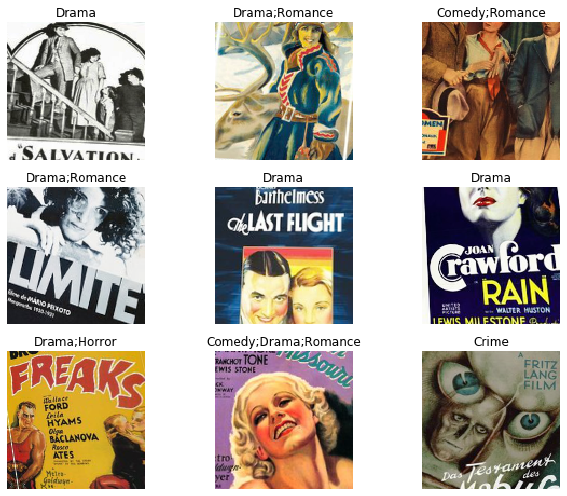

In [19]:
#Show batch of images with designated labels. This verifies that the image databunch has been created correctly. 
data.show_batch(rows=3, figsize=(9,7))

In [20]:
#For data: Show classes, number of classes, number of images in training set, number of images in validation set. 
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Action',
  'Adventure',
  'Animation',
  'Biography',
  'Comedy',
  'Crime',
  'Documentary',
  'Drama',
  'Family',
  'Fantasy',
  'Film-Noir',
  'History',
  'Horror',
  'Music',
  'Musical',
  'Mystery',
  'Romance',
  'Sci-Fi',
  'Short',
  'Sport',
  'Thriller',
  'War',
  'Western'],
 23,
 798,
 199)

In [21]:
#Base architecture resnet50 is chosen.
arch = models.resnet50

In [22]:
#Setup of metrics and learner.
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


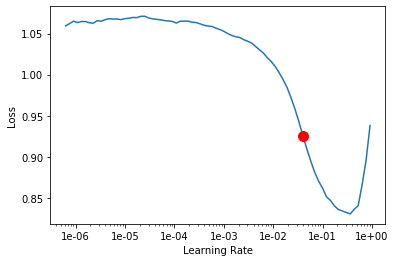

In [23]:
#Search for the optimal learning rate.
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [24]:
#Use suggested learning rate with steepest negative slope.
lr=learn.recorder.min_grad_lr 
lr

0.03981071705534969

In [25]:
learn.save('stage-0')

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.941312,0.597610,0.627922,0.360562,00:03
1,0.608187,0.400262,0.876338,0.504696,00:03
2,0.475994,0.314540,0.869128,0.475756,00:03
3,0.396163,0.279762,0.884641,0.503683,00:03
4,0.339985,0.276598,0.879834,0.510355,00:03


In [27]:
learn.save('stage-1-rn50')

In [28]:
#Unfreeze entire model. Sets every layer group to trainable.
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


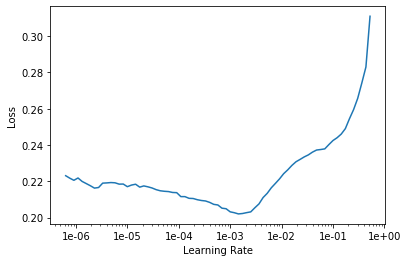

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
#Value 1e-4 is chosen acc to rule of thumb from fast.ai course. 
#Rule of thumb is to choose a value approx 10 times smaller from where the loss starts to increase, in this case approx 1e-3. 
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.218797,0.329167,0.871313,0.405220,00:03
1,0.223555,0.396327,0.854053,0.459701,00:03
2,0.224637,0.385557,0.880926,0.446617,00:03
3,0.209064,0.274323,0.885078,0.486378,00:03
4,0.192084,0.264983,0.888792,0.503510,00:03


In [31]:
learn.save('stage-2-rn50')

In [32]:
#Change size of pictures to 182x182
data = (src.transform(get_transforms(do_flip = False), size=182)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 182, 182])

In [33]:
#Freeze up to last layer group. Sets every layer group except the last to untrainable
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


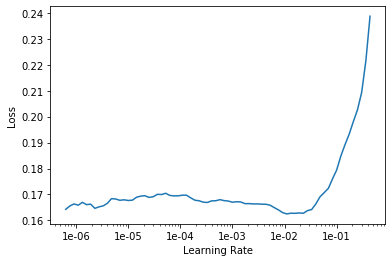

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
lr=1e-3

In [36]:
learn.save('stage-0-182-rn50')

In [37]:
#Only one epoch chosen as the measured values get worse if more epochs are used.
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.170768,0.253114,0.889229,0.527134,00:06


In [38]:
learn.save('stage-1-182-rn50')

In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.164868,0.256826,0.888792,0.521674,00:07
1,0.160248,0.261449,0.883767,0.502454,00:06
2,0.154377,0.260624,0.882674,0.514447,00:06
3,0.146751,0.261764,0.882456,0.516591,00:06
4,0.142635,0.261303,0.884859,0.523274,00:07


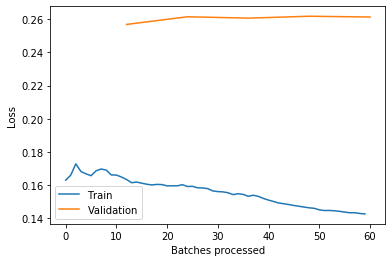

In [41]:
#Plot training and validation loss.
learn.recorder.plot_losses()

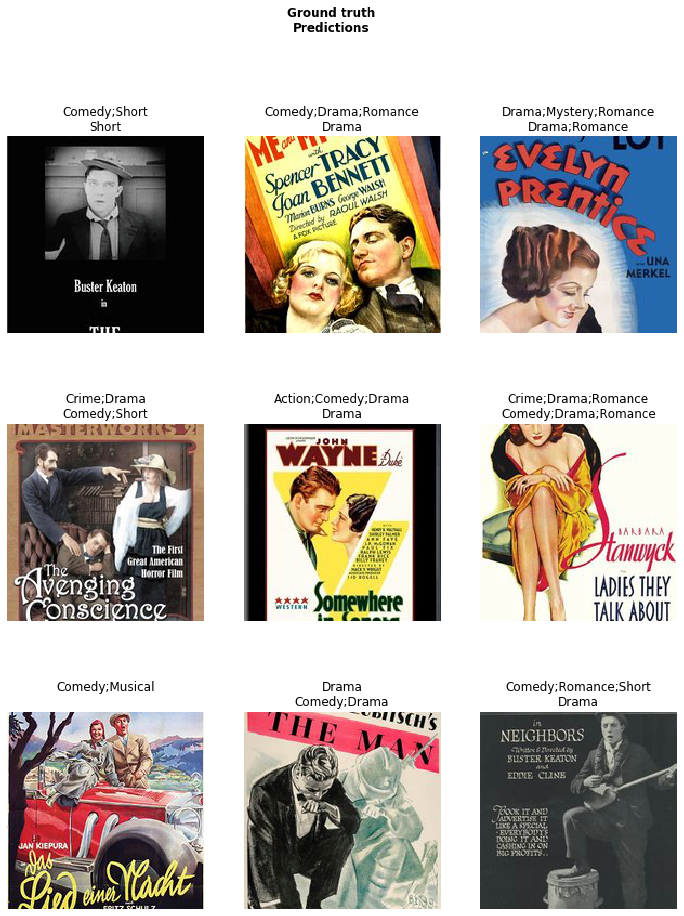

In [49]:
#Show some predictions
learn.show_results(rows=3, figsize=(12,15))

In [42]:
learn.save('stage-2-182-rn50')

In [46]:
#Export the trained model as export.pkl
learn.export()

In [43]:
defaults.device = torch.device('cpu')

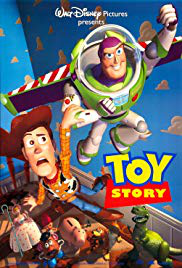

In [44]:
img = open_image(path/'toystory.jpg')
img

In [47]:
#Predict classes for poster from the movie toy story, which was not included in the training or validation set.
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory Animation;Comedy

In [ ]:
#Predicted classes: Animation;Comedy
#Actual classes: Animation|Adventure|Comedy



Only 997 out of totally ca 40 000 images in the complete data set were used for training this model.

The error seems to be surprisingly low, as this could be considered an odd application where a good result could not be expected.

Validation error is a bit higher than the training error. This means that the model, if anything, is leaning towards high variance and overfitting.

Because that the model is closer to overfitting than underfitting adding extra images to the training model should be a good idea. It would generalize better with more data and in turn should make the model perform better.